In [128]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [129]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
#num = [chr(x) for x in range(48,58)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    #print(gene_pool)

    #print(num)
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['NWRakEOvqZMiBMbti',
 'dSVxwStIbmNfrVgfE',
 'cpzJXWAxKsAfeJuOR',
 'ocSLyDUGhvvdbDYBw',
 'YCQaVrbCMMgxpdYFv',
 'cfYqjamaRYXtEWWDT',
 'PCweOrVuoXVJaDBaC',
 'staCQrEATeMjVdQSF',
 'yfwAwwMXtkOAUyvu ',
 'PnfZk xGTfoYCFHDi']

In [130]:
def fitness_fn(sample):
    # TODO: evaluate how close *sample* is to the target
    global target
    fitness = 0
    for gs, gt in zip(sample, target):
        if gs==gt:
            fitness+=1
    return fitness

# test
fitness_fn(init_pop[2])

0

In [131]:
def select(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    fitness = []
    samples = []
    for i in range(len(population)):
        fitness.append((fitness_fn(population[i]), population[i]))
    list.sort(fitness, reverse=True)
    #print(fitness)
    for i in range(r):
        samples.append(fitness[i][1])
    return samples
    #raise NotImplementedError()

# test
parents = select(2, init_pop, fitness_fn)
parents

['dSVxwStIbmNfrVgfE', 'YCQaVrbCMMgxpdYFv']

In [132]:
def recombine(x, y):
    """
    TODO: combine two parents to produce an offspring
    """
    length_x = len(x)
    offspring = ''
    #print(x,y)
    for gp1, gp2 in zip(x,y):
        prob = random.random()
        if prob<=0.5:
            #print(gp1)
            offspring+=gp1
        else:
            #print(gp2)
            offspring+=gp2
        #print(offspring)
    #raise NotImplementedError()
    return offspring

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'dCVaVSbCbMNxrVgFv'

In [133]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population, mutation_rate): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet
        self.max_fitness = len(target)

    def init_population(self, pop_size):
        # raise NotImplementedError()
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        # TODO: evaluate how close *sample* is to the target
        return fitness_fn(sample)
        #raise NotImplementedError()
    
    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        global max_population
        next_gen = []
        a = 450 #child size
        #print(len(population))
        candidates = select(250, population, fitness_fn)
        for i in range(a):
            child = mutate(recombine(random.choice(candidates), random.choice(candidates)), gene_pool, mutation_rate)
            next_gen.append(child)

        return next_gen
        #raise NotImplementedError()
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """

        new_list = []
        old_populations = select(50, old, fitness_fn)
        new_list.extend(old_populations)
        new_list.extend(new)

        return new_list

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            #print(population)
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")
            history.append((gen, list(map(problem.fitness, population))))
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [134]:
# now set up the parameters
ngen = 1000
max_population = 500
mutation_rate = 0.08

sid = 12011702 #TODO:  replace this with your own sid
target = f"fxxking Genetic Algorithm 1278921 by {sid}"
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
alphabet = u_case + l_case +['1','2','3','4','5','6','7','8','9','0']+ [' ']
 # TODO: fix this: what is the search space now?

problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1000,	Best: JDM4inn4zBWmtAFuX9AKap7A6l5sVbN8oglfO1cXnJ3r2,	Fitness=5
Generation: 100/1000,	Best: fxxking Genetyc Algorithm 1278921 by 12011702,	Fitness=44
Generation: 200/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 300/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 400/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 500/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 600/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 700/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 800/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45
Generation: 900/1000,	Best: fxxking Genetic Algorithm 1278921 by 12011702,	Fitness=45


'fxxking Genetic Algorithm 1278921 by 12011702'

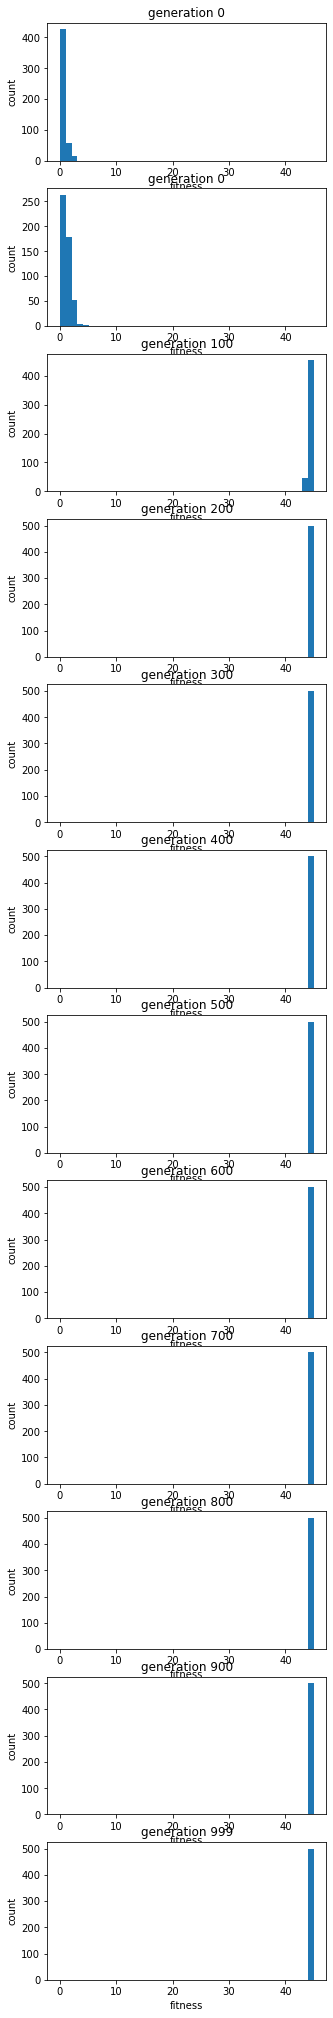

array([ 0.        ,  1.02272727,  2.04545455,  3.06818182,  4.09090909,
        5.11363636,  6.13636364,  7.15909091,  8.18181818,  9.20454545,
       10.22727273, 11.25      , 12.27272727, 13.29545455, 14.31818182,
       15.34090909, 16.36363636, 17.38636364, 18.40909091, 19.43181818,
       20.45454545, 21.47727273, 22.5       , 23.52272727, 24.54545455,
       25.56818182, 26.59090909, 27.61363636, 28.63636364, 29.65909091,
       30.68181818, 31.70454545, 32.72727273, 33.75      , 34.77272727,
       35.79545455, 36.81818182, 37.84090909, 38.86363636, 39.88636364,
       40.90909091, 41.93181818, 42.95454545, 43.97727273, 45.        ])

In [135]:
# visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [136]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs

    def init_population(self, pop_size):
        # TODO:alomost the same as the previous problem.
        populations = []
        que = []
        for i in range(self.n):
            que.append(i)
        for i in range(pop_size):
            random.shuffle(que)
            #print(que)
            que_new = list.copy(que)
            populations.append(que_new)
        #print(populations)
        return populations
        #raise NotImplementedError()
    
    def fitness(self, queens):
        """
        TODO

        hint: count the non-attacking pairs
        """
        #print(queens)
        num = 0
        #print(self.n)
        for i in range(self.n - 1):
            for j in range(i+1, self.n):
                if abs(queens[i] - queens[j]) == abs(i - j) or queens[i] == queens[j]:
                    num = num + 1
        #print('num:', num)
        return self.max_fitness-num
        #raise NotImplementedError()

    def select(self, r, population):
        list.sort(population, key=lambda x:self.fitness(x), reverse=True)
        sample = []
        for i in range(r):
            sample.append(population[i])
        #print(sample)
        return sample

    def recombine(self, x, y):
        offspring = []
        #print(x,y)
        for g1,g2 in zip(x,y):
            #print(g1,g2)
            prop = random.random()
            if prop<=0.5:
                offspring.append(g1)
            else:
                offspring.append(g2)
        return offspring

    def mutation(self, x, mutation_rate):
        if random.random()>mutation_rate:
            return x
        #print('before:',x)
        index = random.randrange(0, len(x))
        x[index] = random.randrange(0, self.n)
        #print(index, index2)
        #print('after:',x)
        return x

    def reproduce(self, population, mutation_rate):
        # TODO:alomost the same as the previous problem.
        child_size = 27
        next_gen = []
        candidates = self.select(10, population)
        #print(candidates)
        for _ in range(child_size):
            child_ = self.mutation(self.recombine(random.choice(candidates), random.choice(candidates)), mutation_rate)
            next_gen.append(child_)

        return next_gen

    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        new_list = []
        old_gen = self.select(3, old)
        new_list.extend(old_gen)
        new_list.extend(new)
        return new

    def __repr__(self):
        return f"{self.n}-Queens Problem"


In [137]:
from utils import plot_NQueens
ngen = 2500
init_size = 30
mutation_rate = 0.5

n = 16
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)
solution

Generation: 0/2500,	Best: [4, 12, 10, 0, 14, 6, 2, 8, 3, 11, 15, 9, 5, 7, 13, 1],	Fitness=115
Generation: 100/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 200/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 300/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 400/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 500/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 600/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 700/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 800/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 900/2500,	Best: [11, 4, 4, 9, 14, 5, 2, 8, 12, 0, 15, 3, 7, 10, 13, 1],	Fitness=119
Generation: 1000/2500,	Best: [11, 4, 4, 9,

[8, 4, 11, 1, 14, 5, 0, 9, 12, 2, 15, 3, 7, 10, 13, 6]

D:\AI_Labs\Practice7(DDL1111)\utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


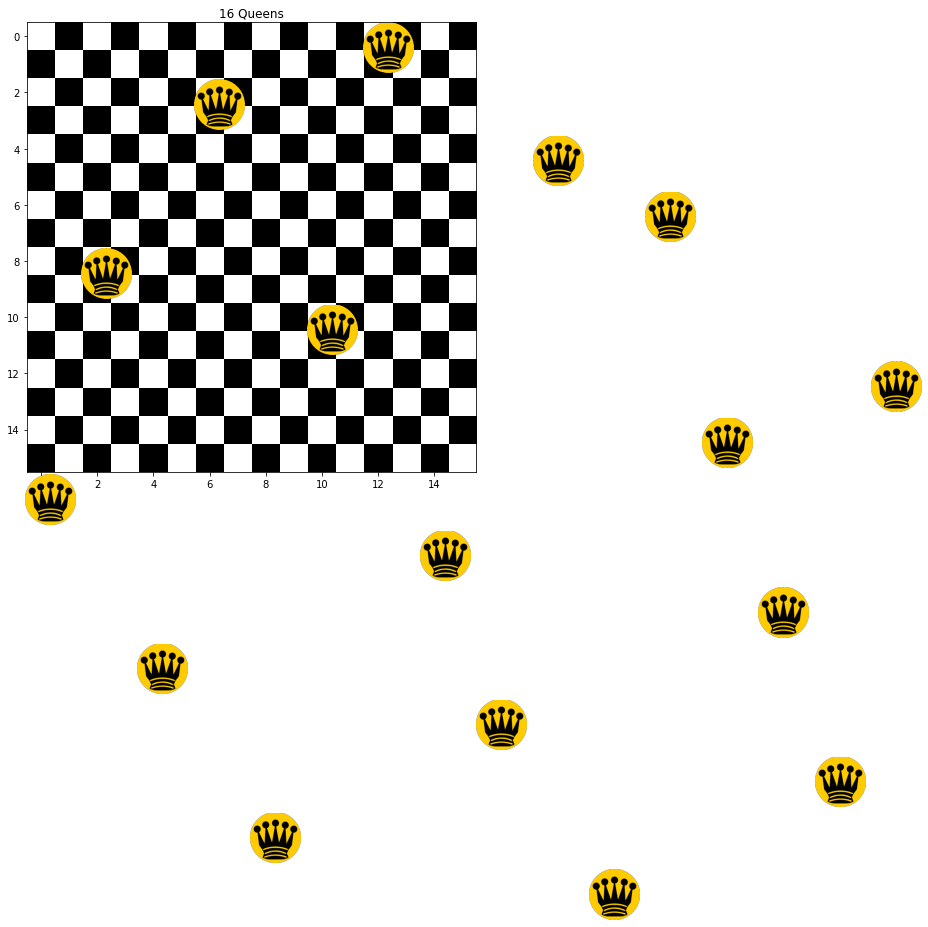

In [138]:
# Example of how to use this function
#plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
plot_NQueens(solution)

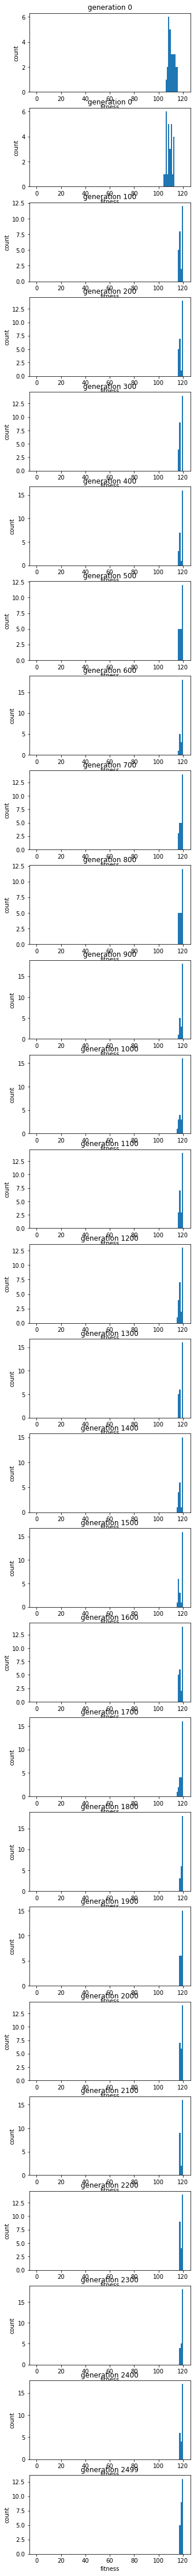

In [139]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)